In [1]:
%matplotlib inline

In [911]:
import pickle
from collections import Counter, namedtuple

import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
np.set_printoptions(precision=4, suppress=True)

In [3]:
from tqdm import tqdm

def cleanup_graph(G):
    for node_id, data in G.nodes_iter(data=True):
        # 'scores' already contain all the information needed for rewards
        if 'info' in data and 'forms' in data['info']:
            del data['info']['forms']
        if 'info' not in data:
            data['ok'] = False
            
    for _, _, data in G.edges_iter(data=True):
        if 'link' in data:
            link = data['link']
            url = link['url']
            text = link.get('inside_text', '')
            data.clear()
            data.update(url=url, text=text)
    return G

In [4]:
graph_paths = !ls ../deep-deep/data/alexa-*depth3.pickle

In [5]:
#G = nx.read_gpickle('graph-50-d2.pickle')
graphs = [nx.read_gpickle(path) for path in tqdm(graph_paths)]
# G = nx.read_gpickle('../deep-deep/data/alexa-aa.csv.graph-depth3.pickle')
# cleanup_graph(G)

100%|██████████| 10/10 [01:30<00:00,  8.19s/it]


In [6]:
graphs = [cleanup_graph(g) for g in tqdm(graphs)]

100%|██████████| 10/10 [00:22<00:00,  2.36s/it]


Edge information:

In [7]:
G = graphs[0]

In [8]:
G.edges(data=True)[100]

(3,
 1343,
 {'text': 'Copyright Compliance',
  'url': 'http://www.cc.com/legal/copyright-compliance'})

Node information:

In [1027]:
from urllib.parse import unquote_plus
from urllib.parse import urlsplit

def url_path_query(url):
    """
    Return URL path and query, without domain, scheme and fragment:

    >>> url_path_query("http://example.com/foo/bar?k=v&egg=spam#id9")
    '/foo/bar?k=v&egg=spam'
    """
    p = urlsplit(url)
    return unquote_plus(p.path + '?' + p.query).lower()

url_path_query("http://example.com/foo/bar?k=v&egg=spam#id9")

'/foo/bar?k=v&egg=spam'

In [9]:
G.node[500]

{'info': {'depth': 2,
  'domain': 'vezess',
  'scores': {'contact/comment': 0.0011033732400266506,
   'join mailing list': 0.001686975891374705,
   'login': 0.0015837758713771791,
   'order/add to cart': 0.0023456014612122313,
   'other': 0.0056311741844204087,
   'password/login recovery': 0.00054091350886275799,
   'registration': 0.0003751461409411641,
   'search': 0.98673303970178505}},
 'ok': True,
 'original_url': 'http://www.vezess.hu/magazin/2016/05/27/felnijavitas_festes_homokfuvas/',
 'url': 'http://www.vezess.hu/magazin/2016/05/27/felnijavitas_festes_homokfuvas/',
 'visited': True}

The graph is used as an experience replay storage.
We're using action-value $Q(a)$ functions with Q-learning algorithm. To learn Q function we need "training examples": 

* $a_t$ action taken (i.e. link followed);
* $r_{t+1}$ observed reward (e.g. whether a form is found or is a page on-topic);
* a set of actions $A_{t+1}$ (i.e. links) available at this page; next action $a_{t+1} \in A_{t+1}$ used for TD updates is chosen from this set. In Q-learning it is a link with the highest $Q(a_{t+1})$ score; we need to store all available actions because $Q$ function changes over time.
* discount $\gamma$? How does it work? There is a footnote in http://arxiv.org/pdf/1511.05952v4.pdf

$$R_{predicted} = Q(a_t)$$
$$R_{observed TD} = r_{t+1} + \gamma*Q(a_{t+1}), 0 < \gamma < 1$$

We can sample these training examples from the graph by getting visited nodes which has predcessors.

In [10]:
def get_visited_nbunch(G):
    return [
        node_id for node_id, data in G.nodes(data=True) if data['visited'] and data['ok']
    ]

len(get_visited_nbunch(G))

49731

possible form types:

* contact/comment
* join mailing list
* login
* order/add to cart
* other
* password/login recovery
* registration
* search

In [776]:
def get_reward(node):
    return node['info']['scores'].get('password/login recovery', 0)
            

def _iter_examples(G, nbunch):
    for node_id in nbunch:
        for from_, _, link in G.in_edges_iter(node_id, data=True):
            if not link:
                continue
            yield node_id, link

            
def iter_examples(G):
    nbunch = get_visited_nbunch(G)
    for node_id, link in _iter_examples(G, nbunch):
        reward = get_reward(G.node[node_id])
        
        # FIXME: what to do with dupefilter?
        actions = list(G[node_id].values())
        yield {
#             'node_id': node_id,
            'link': link, 
            'reward': reward, 
            'actions': actions
        }


def get_examples(G):
    return list(iter_examples(G))

def get_combined_examples(graphs):
    res = []
    for G in graphs:
        res.extend(iter_examples(G))
    return res

In [805]:
%%time
# examples = get_combined_examples(tqdm(graphs))
examples = get_examples(graphs[1])
print(len(examples))

49692
CPU times: user 504 ms, sys: 0 ns, total: 504 ms
Wall time: 504 ms


In [806]:
pos = [e for e in examples if e['reward'] > 0.5]
neg = [e for e in examples if e['reward'] <= 0.5]

In [807]:
len(pos), len(neg)

(826, 48866)

In [808]:
pos[110]

{'actions': [],
 'link': {'text': "Event.observe('product-image-31', 'mouseover', function() {\r\n\t\t\t\t\t\t\t\t\t$('product-image-31').src = 'http://media.fashionesta.com/media/catalog/product/cache/7/small_image/205x255/5e06319eda06f020e43594a9c230972d/4/1/41059_2.jpg';\r\n\t\t\t\t\t\t\t\t});\r\n\t\t\t\t\t\t\t\tEvent.observe('product-image-31', 'mouseout', function() {\r\n\t\t\t\t\t\t\t\t\t$('product-image-31').src = 'http://media.fashionesta.com/media/catalog/product/cache/7/small_image/205x255/5e06319eda06f020e43594a9c230972d/4/1/41059_1.jpg';\r\n\t\t\t\t\t\t\t\t});",
  'url': 'http://www.fashionesta.com/us/gucci-top-rose.html'},
 'reward': 0.530292915244297}

In [809]:
from collections import Counter
from formasaurus.utils import get_domain

Problem 1: there is a LOT of non-interesting links for some of domains.

It means experience replay should take positive examples from multiple domains. For example, it there are 3 interesting pages on domain A (out of 500), and 300 interesting pages on domain B (out of 500) then it makes sense to sample positive examples from A more often.

Problem 2: data can be very imbalanced. It may worth trying to sample a fixed fraction of positive examples (see e.g. http://people.csail.mit.edu/karthikn/pdfs/mud-play15.pdf).

In [810]:
pos_domains = [get_domain(r['link']['url']) for r in pos]
neg_domains = [get_domain(r['link']['url']) for r in neg]
len(set(pos_domains)), len(set(neg_domains))

(21, 75)

In [811]:
Counter(pos_domains).most_common()

[('fashionesta', 641),
 ('fiestamericana', 158),
 ('aleksius', 4),
 ('tyreleader', 2),
 ('omb100', 2),
 ('csindy', 2),
 ('airportrentals', 2),
 ('bloomberg', 2),
 ('z0r', 1),
 ('guiadacidade', 1),
 ('videostar', 1),
 ('kixer', 1),
 ('dynamomania', 1),
 ('uai', 1),
 ('thevitalounge', 1),
 ('waymarking', 1),
 ('chemodan', 1),
 ('hq-mirror', 1),
 ('webmasterpark', 1),
 ('leechdrive', 1),
 ('henho', 1)]

Let's train a baseline classifier based on these examples.

In [1098]:
from sklearn.cross_validation import train_test_split, cross_val_score, cross_val_predict, LabelKFold
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    mean_squared_error,
    mean_absolute_error,
)
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline, make_union
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import (
    LogisticRegression, 
    LogisticRegressionCV,
    LinearRegression, 
    SGDRegressor, 
    ElasticNetCV, 
    ElasticNet
)

In [1024]:
# def get_annotation_folds(X, n_folds):
#     """
#     Return (train_indices, test_indices) folds iterator.
#     It is guaranteed forms from the same website can't be both in
#     train and test parts.
#     """
#     return LabelKFold(
#         labels=[get_domain(ann.url) for ann in annotations],
#         n_folds=n_folds
#     )

def get_y(examples):
    return np.asarray([ex['reward'] for ex in examples])

def get_X(examples):
    return np.asarray([ex['link']['text'] for ex in examples])

In [1050]:
BAD_DOMAINS_RECOVER = {'12gebrauchtwagen', 'tagcome', 'nyrr'}
BAD_DOMAINS_REGISTER = {'safarinow'}

good_examples = [
    ex for ex in examples 
#     if get_domain(ex['link']['url']) not in BAD_DOMAINS_RECOVER
]
X = get_X(good_examples)
y = get_y(good_examples)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [1049]:
# from unbalanced_dataset.under_sampling import RandomUnderSampler

# US = RandomUnderSampler(verbose=True, ratio=0.01)
# usX_train, usy_train = US.fit_transform(X_train.reshape(-1, 1), y_train)
# usX_train = usX_train.reshape(-1)
# usX_train.shape, usy_train.sum()

In [1051]:
def plot_histograms(y_pred, y_test):
    df = pd.DataFrame(columns=['y_pred', 'y_test'])
    df['y_pred'] = y_pred
    df['y_test'] = y_test
    df.hist(sharex=True, sharey=True, bins=50, figsize=(12,5))
    return df

In [1099]:
# vec = CountVectorizer(analyzer='char', ngram_range=(4, 5), strip_accents='unicode')
vec = HashingVectorizer(
    binary=True, 
    n_features=1000000,
    non_negative=False,
    norm='l2',
#     strip_accents='unicode',
    ngram_range=(1,2)
)
vec = CountVectorizer(binary=True, ngram_range=(1, 2))

# url_vec = CountVectorizer(
#     binary=True, 
#     preprocessor=url_path_query,
#     analyzer='char',
#     ngram_range=(4,4)
# )

clf = SGDRegressor(
    penalty='l2',
    average=False, 
    n_iter=1, 
    learning_rate='constant',
#     loss='epsilon_insensitive', 
#     loss='', 
    alpha=1e-6, 
    eta0=1.0,
)
pipe = make_pipeline(vec, clf)

In [1089]:
clf.coef_

In [1132]:
m = vec.transform(['привет мир', 'мир', 'ура!', 'кто-то что-то сказал'])
# m.shape
m * (np.random.randint(0, 2, size=m.shape[1])*2 - 1).T

array([2, 1, 0, 6], dtype=int64)

In [1137]:
from scipy import sparse as sp
size = m.shape[1]

diag = sp.diags(np.random.randint(0, 2, size=size)*2 - 1)
m.dot(diag).mean()

2.1402460426850669e-06

In [ ]:
class 

In [1134]:
m.data

array([1, 1, 1, 1, 1, 1, 1, 1, 1])

In [1102]:
%%time
SIZE = -1
# pipe.fit(usX_train, usy_train)
pipe.fit(X_train[:SIZE], y_train[:SIZE])
y_pred = pipe.predict(X_test)
y_pred[y_pred < 0] = 0

CPU times: user 1.6 s, sys: 0 ns, total: 1.6 s
Wall time: 1.6 s


In [1092]:
y_train[:SIZE][y_train[:SIZE] > 0.5].sum()

336.29458299421538

{'alpha': 1e-06,
 'average': False,
 'epsilon': 0.1,
 'eta0': 1.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'constant',
 'loss': 'squared_loss',
 'n_iter': 1,
 'penalty': 'l2',
 'power_t': 0.25,
 'random_state': None,
 'shuffle': True,
 'verbose': 0,
 'warm_start': False}

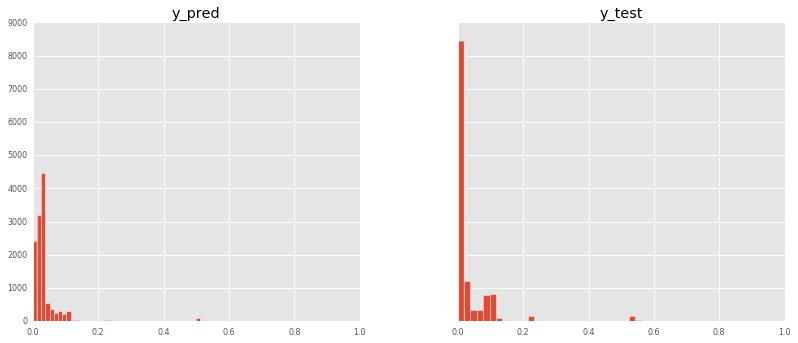

In [1093]:
df = plot_histograms(y_pred, y_test)
clf.get_params()

In [1094]:
def loss(y_true, y_pred, threshold=0.5, k=10.0):
    sample_weight = np.ones_like(y_true)
    sample_weight[y_true > threshold] = k
    return mean_squared_error(y_true, y_pred, sample_weight)

In [1095]:
y_0 = np.zeros_like(y_test, dtype=np.float)
y_mean = np.ones_like(y_test) * y_test.mean()
print("dummy zero: mse={:0.4f}, weighted={:0.4f}".format(
    mean_squared_error(y_test, y_0),
    loss(y_test, y_0),
))
print("dummy mean: mse={:0.4f}, weighted={:0.4f}".format(
    mean_squared_error(y_test, y_mean),
    loss(y_test, y_mean)
))

print("clf:        mse={:0.4f}, weighted={:0.4f}".format(
    mean_squared_error(y_test, y_pred),
    loss(y_test, y_pred)
))

print("coef norm={:0.4f} max={:0.4f}".format(    
    (clf.coef_ ** 2).sum(),
    clf.coef_.max(),
))

dummy zero: mse=0.0078, weighted=0.0491
dummy mean: mse=0.0067, weighted=0.0431
clf:        mse=0.0031, weighted=0.0188
coef norm=45.5285 max=1.0279


In [1096]:
pipe.predict(['forgot password', 'registration', 'my little pony', 'comment', 'sign in', 'forum', 'забыли пароль'])

array([ 0.6395, -0.0025,  0.0132,  0.1353, -0.0075, -0.0039,  0.4554])

In [1060]:
indices = set(np.where(clf.coef_ > 0.5)[0])
[w for w, idx in vec.vocabulary_.items() if idx in indices]

AttributeError: 'HashingVectorizer' object has no attribute 'vocabulary_'

In [511]:
# np.where(clf.coef_ > 0.3)[0]

In [1080]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
#     tick_marks = np.arange(len(iris.target_names))
#     plt.xticks(tick_marks, iris.target_names, rotation=45)
#     plt.yticks(tick_marks, iris.target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)    

In [48]:
pos[0]

{'actions': [{'text': '', 'url': 'https://www.icontact.com/login-pro'},
  {'text': 'Privacy Policy',
   'url': 'https://www.icontact.com/legal/privacy-policy-2016'}],
 'link': {'text': 'Upgrade to a full account today',
  'url': 'https://www.icontact.com/login?loginText=upgrade'},
 'node_id': 288,
 'reward': 0.97704821622819793}